In [1]:
!pip install torchtext==0.6

In [2]:
from torchtext.data import Field, TabularDataset, BucketIterator,LabelField
from tqdm.notebook import tqdm
from torchtext.vocab import GloVe

# Essential libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch
from sklearn.model_selection import train_test_split
print(torch.__version__)

2.0.1+cu118


In [3]:
SEED = 1234
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load the original dataset
df = pd.read_csv('missom_coded_v1_santosh.csv')
df = df.rename(columns={'label_minority_stress': 'label'})
df = df[['text', 'label']]

empty_cells =  df.isnull().sum()
print(empty_cells)
df.dropna(inplace = True)

empty_cells =  df.isnull().sum()
print(empty_cells)



text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

train_ratio = 0.65
valid_ratio = 0.15
test_ratio = 0.20

train_df, remaining_df = train_test_split(df, test_size=1 - train_ratio, random_state=random.seed(SEED))
valid_df, test_df = train_test_split(remaining_df, test_size=test_ratio/(valid_ratio + test_ratio), random_state=random.seed(SEED))

# Save the dataframes to CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

In [6]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = LabelField(dtype = torch.float)

In [7]:
# Load the data
train_data,valid_data, test_data = TabularDataset.splits(
    path= '/content/',
    train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv',
    fields=[('text', TEXT), ('label', LABEL)],
    skip_header=True
)
print('Number of training examples: {}'.format(len(train_data)))
print('Number of Validation examples: {}'.format(len(valid_data)))
print('Number of testing examples: {}'.format(len(test_data)))
print(train_data[0])

Number of training examples: 3762
Number of Validation examples: 868
Number of testing examples: 1159


In [19]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)


# TEXT.build_vocab(train_data, min_freq = 3)
# LABEL.build_vocab(train_data)

In [20]:
BATCH_SIZE = 4

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True
    )

In [21]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=bidirectional,
                          dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, hidden = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        return self.fc(hidden)


In [22]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)


In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 3,843,721 trainable parameters


In [24]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5149, -1.1110, -2.3959,  ..., -1.2926,  1.3179,  0.7111],
        ...,
        [-1.5735, -1.5525,  1.1222,  ...,  0.1801,  1.5828, -0.3978],
        [-1.0724,  0.2503, -1.5791,  ...,  1.0643, -2.3240, -0.1631],
        [ 0.8638, -1.1965, -0.0393,  ..., -1.1439,  0.2929, -1.2133]])


In [25]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [26]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()
        text, text_lengths = batch.text

        predictions = model(text, text_lengths)

        loss = criterion(predictions, batch.label.unsqueeze(1))

        acc = binary_accuracy(predictions, batch.label.unsqueeze(1))

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text, text_lengths = batch.text

            predictions = model(text, text_lengths)


            loss = criterion(predictions, batch.label.unsqueeze(1))
            acc = binary_accuracy(predictions, batch.label.unsqueeze(1))

            epoch_loss += loss.item()
            epoch_acc += acc.item()


    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
def calc_report(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    y_pred = []
    y_true = []

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text, text_lengths = batch.text
            labels = batch.label

            predictions = model(text, text_lengths)

            threshold = 0.5
            output_1 = (predictions > threshold).int()
            y_pred.extend(output_1.tolist())
            y_true.extend(labels.tolist())

            loss = criterion(predictions, batch.label.unsqueeze(1))
            acc = binary_accuracy(predictions, batch.label.unsqueeze(1))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            rep = classification_report(y_true, y_pred, labels=[1,0], digits=2)

    return rep

In [28]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.525 | Train Acc: 78.80%
	 Val. Loss: 0.527 |  Val. Acc: 77.19%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.495 | Train Acc: 78.69%
	 Val. Loss: 0.520 |  Val. Acc: 76.38%
Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.480 | Train Acc: 78.96%
	 Val. Loss: 0.527 |  Val. Acc: 77.30%
Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.460 | Train Acc: 79.52%
	 Val. Loss: 0.538 |  Val. Acc: 72.58%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.430 | Train Acc: 81.06%
	 Val. Loss: 0.559 |  Val. Acc: 77.07%
Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 0.409 | Train Acc: 81.67%
	 Val. Loss: 0.559 |  Val. Acc: 73.39%
Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 0.384 | Train Acc: 82.84%
	 Val. Loss: 0.599 |  Val. Acc: 76.38%
Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.364 | Train Acc: 84.14%
	 Val. Loss: 0.573 |  Val. Acc: 70.97%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 0.339 | Train Acc: 85.02%
	 Val. Loss: 0.550 |  Val. Acc: 75.58%
Epoch: 10 | Epoch T

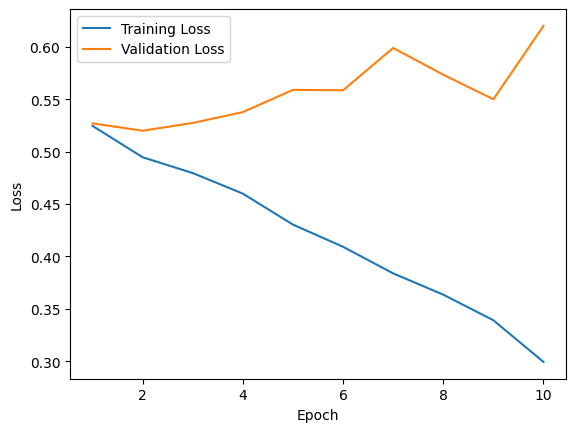

In [30]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

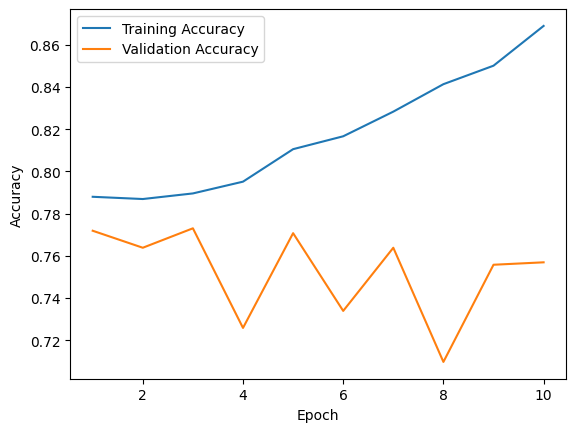

In [31]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
cal = calc_report(model, test_iterator, criterion)
print(cal)

              precision    recall  f1-score   support

           1       0.43      0.17      0.24       249
           0       0.81      0.94      0.87       910

    accuracy                           0.77      1159
   macro avg       0.62      0.55      0.55      1159
weighted avg       0.73      0.77      0.73      1159



https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb